# Step 1: Load Data

In [1]:
import sys
import os
from transformers import AutoTokenizer
from pathlib import Path

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.dataset.scdnam_dataset import TokensRatiosDataset, scDNAm_collate_TokensRatios

tokenizer = AutoTokenizer.from_pretrained(f"../src/tokenizers/scdnam_6mer", trust_remote_code=True)
ESC = {}
ESC["human_esc"] = TokensRatiosDataset(
    csv_file="human_esc/data/human_esc.csv",
    root_path="human_esc/data/scWGBS_with_nucleotide_change_10mer_tokens_npz",
    K_mer="6mer", tokenizer=tokenizer, type_json_path="human_esc/data/human_esc_type.json",
    need_labels=True,
    need_analysis=True,
    max_length = 10_000_000,  # A100 (80GB) handles 10M, H200 handles 20M. Set to 1.6M CpGs for quick testing.
    random=False,
    use_sample=False,
    use_truncation=False,
    start_idx=0,
    selective_chrs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],
)
data_collator = scDNAm_collate_TokensRatios(tokenizer=tokenizer)

output_dir = Path("output_dir")
output_dir.mkdir(parents=True, exist_ok=True)

In [2]:
ESC["human_esc"][0]

{'unmethy_input_ids': array([  0,  23,  11, ..., 245, 245,   2]),
 'methy_input_ids': array([  0,  24,  12, ..., 246, 246,   2]),
 'methy_ratios': array([1., 0., 1., ..., 0., 0., 1.]),
 'positions': array([       0,    10542,    10563, ..., 50808246, 50808252,        0]),
 'chrs': array([ 0,  1,  1, ..., 22, 22,  0]),
 'file_names': 'GSM2833169.bed_with_sequence.npz',
 'labels': 4}

# Step 2: Load Model

In [3]:
from inference.inference import scDNAmGPTForAnalysis

model = scDNAmGPTForAnalysis.from_pretrained(
    tokenizer=tokenizer,
    pretrained_model_name="human_esc/model",
    num_labels=ESC["human_esc"].num_labels,
    attention_mechanism={
      "projection_dim": 256,
      "attention_num_heads": 8,
      "dropout_rate": 0.1},
    cross_attn_every_hidden_states=True
)

# Move model to device
device = "cuda:0"
model.to(device)  
model.eval() 

------------------------------------------
Shape of lm_head.weight:  torch.Size([520, 128]) 
------------------------------------------
[Missing keys]:
  - lm_head.weight


scDNAmGPTForAnalysis(
  (backbone): scDNAmMixerModel(
    (embedding): Embedding(520, 128)
    (layers): ModuleList(
      (0-7): 8 x Block(
        (norm): RMSNorm()
        (mixer): Mamba(
          (in_proj): Linear(in_features=128, out_features=512, bias=False)
          (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
          (act): SiLU()
          (x_proj): Linear(in_features=256, out_features=40, bias=False)
          (dt_proj): Linear(in_features=8, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=128, bias=False)
        )
      )
    )
    (norm_f): RMSNorm()
  )
  (lm_head): Linear(in_features=128, out_features=520, bias=False)
  (query_proj_layers): ModuleList(
    (0-8): 9 x Linear(in_features=128, out_features=256, bias=True)
  )
  (key_proj_layers): ModuleList(
    (0-8): 9 x Linear(in_features=128, out_features=256, bias=True)
  )
  (value_proj_layers): ModuleList(
    (0-8): 9 x Linear(in_feat

# Step 3: Inference

In [4]:
from inference.inference import run_inference_on_dataset

run_inference_on_dataset(
    model, ESC["human_esc"], tokenizer, data_collator, 
    device, output_dir, "human_esc", 
    batch_size=1
)

Inferencing: 100%|████████████████████| 280/280 [43:54<00:00,  9.41s/batch, current_samples=1/280, latest_file=SRR6228520...] 


# Step 4: Cell Embeddings

In [5]:
# === Minimal version: CSV -> array loading -> AnnData ===
import os
import numpy as np
import pandas as pd
import scipy.sparse as sp
import anndata as ad

# ---------- Config ----------
CSV_PATH  = "output_dir/human_esc/human_esc_inference_results.csv"
DATA_DIR  = "output_dir/human_esc/norm_attn_outputs"
FILTER_MATCHED = False  # If CSV has 'predictions' and you only want rows where labels==predictions, set True

# Numeric label -> text label
LABEL_MAP = {
    0: "2-cell embryo",
    1: "4-cell embryo",
    2: "8-cell embryo",
    3: "hESC",
    4: "Inner cell mass",
    5: "Oocyte",
    6: "Sperm",
    7: "Trophoectoderm cells",
    8: "Zygote",
    9: "Morula"
}

# Display order for text labels
ORDER = [
    "Sperm",
    "Oocyte",
    "Zygote",
    "2-cell embryo",
    "4-cell embryo",
    "8-cell embryo",
    "Morula",
    "Inner cell mass",
    "Trophoectoderm cells",
    "hESC",
]

# ---------- Utilities ----------
def load_array(path: str):
    """Load .npz/.npy; if 2D+, reduce via axis=0 sum; convert sparse to dense; return 1D ndarray."""
    if not os.path.exists(path):
        return None
    try:
        obj = np.load(path, allow_pickle=True)
        if isinstance(obj, np.lib.npyio.NpzFile):
            key = "data" if "data" in obj.files else obj.files[0]
            arr = obj[key]
        else:
            arr = obj  # .npy is already an ndarray

        if sp.issparse(arr):
            arr = arr.toarray()

        if arr.ndim > 1:
            arr = arr.sum(axis=0)  # aggregate to a 1D feature vector across layers

        return np.asarray(arr).ravel()
    except Exception as e:
        print(f"[skip] {os.path.basename(path)} -> {e}")
        return None

def build_anndata(csv_path: str, data_dir: str, filter_matched: bool = False):
    df = pd.read_csv(csv_path)

    if filter_matched and {"labels", "predictions"}.issubset(df.columns):
        df = df[df["labels"] == df["predictions"]]

    X, obs_rows = [], []
    missing = 0

    for _, row in df.iterrows():
        file_name = row["file_name"]
        label_id = row["labels"]
        path = os.path.join(data_dir, file_name)

        arr = load_array(path)
        if arr is None:
            missing += 1
            continue

        X.append(arr)
        obs_rows.append({"file_name": file_name, "label_id": label_id})

    if not X:
        return None, {"n_rows": 0, "n_features": 0, "missing": missing}

    X = np.vstack(X)
    obs = pd.DataFrame(obs_rows)
    obs["cell_type"] = obs["label_id"].map(LABEL_MAP)
    obs["cell_type"] = pd.Categorical(obs["cell_type"], categories=ORDER, ordered=True)

    adata = ad.AnnData(X=X, obs=obs[["file_name", "cell_type", "label_id"]])
    return adata, {"n_rows": X.shape[0], "n_features": X.shape[1], "missing": missing}

# ---------- Main ----------
adata, info = build_anndata(CSV_PATH, DATA_DIR, filter_matched=FILTER_MATCHED)

if adata is None or info["n_rows"] == 0:
    print("No matching data found. Cannot create AnnData.")
else:
    print(f"AnnData: {info['n_rows']} cells × {info['n_features']} features (skipped {info['missing']} missing/corrupted files)")
    # Optional save:
    adata.write(f"{output_dir}/human_esc/human_esc.h5ad")

AnnData: 280 cells × 256 features (skipped 0 missing/corrupted files)


/root/miniconda3/envs/scDNAm_GPT/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Step5: Pseudotime Export

In [6]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse.csgraph import connected_components
from pandas.api.types import is_numeric_dtype, is_categorical_dtype

adata_path = f"{output_dir}/human_esc/human_esc.h5ad"
adata = sc.read_h5ad(adata_path)

n_pcs = 50
n_neighbors = 100
metric = "euclidean"
SEED = 42
prefix = "human_esc"

LABELS_ORDERED = [
    "Sperm", "Oocyte", "Zygote",
    "2-cell embryo", "4-cell embryo", "8-cell embryo",
    "Morula", "Trophoectoderm cells", "Inner cell mass"
]

def preprocess_data(adata, labels_ordered):
    """Filter out hESC and ensure ordered categorical cell_type with stage_rank."""
    # Remove hESC samples
    adata = adata[adata.obs["cell_type"] != "hESC"].copy()

    # If cell_type is numeric (or categorical with numeric categories), map to labels
    cell_type = adata.obs["cell_type"]
    if (is_numeric_dtype(cell_type) or
        (is_categorical_dtype(cell_type) and is_numeric_dtype(cell_type.cat.categories))):
        num2label = {i: lbl for i, lbl in enumerate(labels_ordered)}
        adata.obs["cell_type"] = cell_type.astype(int).map(num2label)

    # Enforce ordered categories and compute stage_rank
    adata.obs["cell_type"] = pd.Categorical(
        adata.obs["cell_type"], categories=labels_ordered, ordered=True
    )
    adata.obs["stage_rank"] = adata.obs["cell_type"].cat.codes
    return adata

def largest_component_root(ad):
    """
    Pick the root cell as the one with the smallest stage_rank
    inside the largest connected component of the neighbor graph.
    """
    if "neighbors" not in ad.uns:
        raise KeyError("Neighbors graph not found. Run sc.pp.neighbors() first.")
    G = ad.obsp.get(ad.uns["neighbors"].get("connectivities_key", "connectivities"))
    _, labels = connected_components(G)
    largest = np.argmax(np.bincount(labels))
    sub_idx = np.where(labels == largest)[0]
    iroot_rel = np.argmin(ad.obs.iloc[sub_idx]["stage_rank"].to_numpy())
    return sub_idx[iroot_rel]

# ---- Compute neighbors / DiffMap / DPT / UMAP (no plotting) ----
adata = preprocess_data(adata, LABELS_ORDERED)

sc.pp.pca(adata, n_comps=100, svd_solver="arpack", random_state=SEED)

sc.pp.neighbors(adata, n_pcs=n_pcs, n_neighbors=n_neighbors, metric=metric, random_state=SEED)
sc.tl.diffmap(adata, random_state=SEED)
adata.uns["iroot"] = largest_component_root(adata)
sc.tl.dpt(adata)

# Ensure UMAP is available
if "X_umap" not in adata.obsm:
    sc.tl.umap(adata, min_dist=0.3, random_state=SEED)

# ---- Assemble and export CSV ----
umap = adata.obsm["X_umap"]
df_out = pd.DataFrame({
    "celltype": adata.obs["cell_type"].astype(str).values,
    "stage_rank": adata.obs["stage_rank"].astype(int).values,  # add this column
    "pesudotime": adata.obs["dpt_pseudotime"].values,
    "umap_1": umap[:, 0],
    "umap_2": umap[:, 1],
})

os.makedirs(output_dir, exist_ok=True)
out_csv = os.path.join(output_dir, f"human_esc/{prefix}_umap_pesudotime.csv")
df_out.to_csv(out_csv, index=False)
print(f"[OK] Saved: {out_csv}  (rows={len(df_out)})")

/tmp/ipykernel_1785844/1173885602.py:31: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  (is_categorical_dtype(cell_type) and is_numeric_dtype(cell_type.cat.categories))):


[OK] Saved: output_dir/human_esc/human_esc_umap_pesudotime.csv  (rows=258)


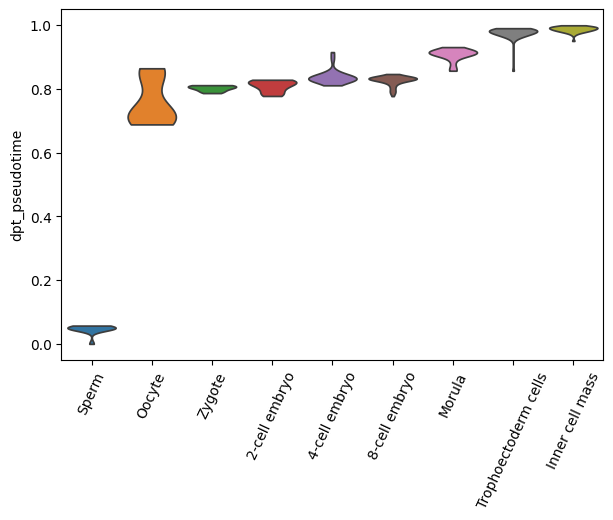

<Figure size 700x700 with 0 Axes>

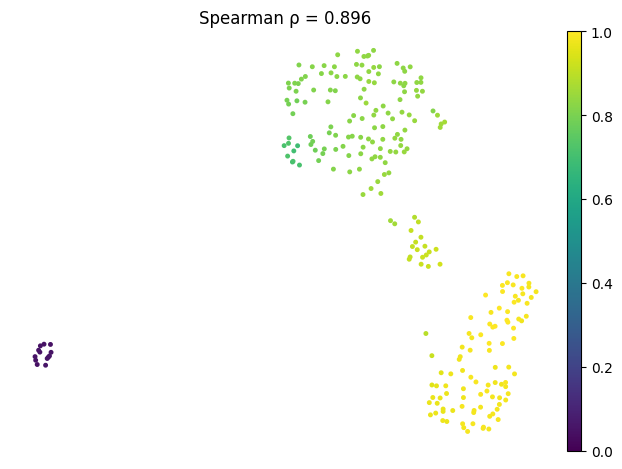

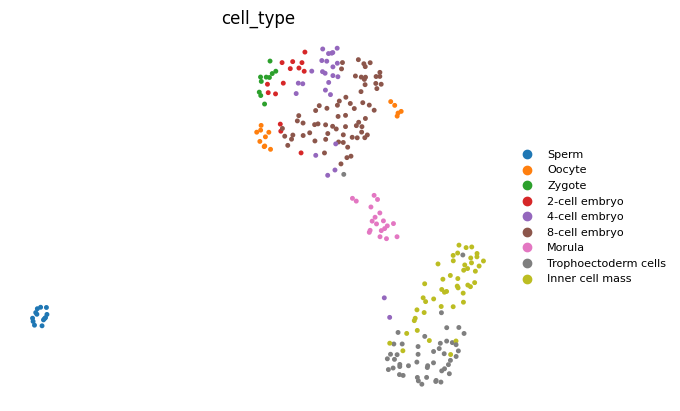

In [7]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

spearman_rho, _ = spearmanr(adata.obs["dpt_pseudotime"], adata.obs["stage_rank"], nan_policy="omit")

# Violin 图
sc.pl.violin(adata, keys="dpt_pseudotime", groupby="cell_type", order=LABELS_ORDERED, stripplot=False, jitter=False, rotation=65, show=True)

# 确保 UMAP 已经计算
if 'X_umap' not in adata.obsm:
    sc.pp.neighbors(adata, n_pcs=n_pcs, n_neighbors=n_neighbors, metric=metric, random_state=SEED)
    sc.tl.umap(adata, min_dist=0.3, random_state=SEED)

# 在 UMAP 图上添加 spearman_rho 值
plt.figure(figsize=(7, 7))
sc.pl.umap(adata, color="dpt_pseudotime", frameon=False, cmap="viridis", size=50, legend_loc=None, show=False)
plt.title(f"Spearman ρ = {spearman_rho:.3f}", fontsize=12)
plt.tight_layout()
plt.show()

# UMAP 图（cell_type）
sc.pl.umap(adata, color="cell_type", frameon=False, size=50, legend_loc="right margin", legend_fontsize=8, legend_fontoutline=2, show=True)